In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import re
import nltk
import string
import xgboost
from textblob import Word
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn import decomposition
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import svm, naive_bayes, ensemble, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

In [3]:
import warnings
warnings.filterwarnings("ignore")    # Ignore all warnings

In [4]:
data = pd.read_excel("bankreviews.xlsx")

In [5]:
data.head()

,Date,Stars,Reviews,BankName
0,2017-04-10,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage
1,2017-02-10,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage
2,2017-08-21,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage
3,2017-12-17,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage
4,2016-05-27,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
Date        505 non-null datetime64[ns]
Stars       505 non-null int64
Reviews     505 non-null object
BankName    505 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 15.9+ KB


In [7]:
TextBlob(data['Reviews'][0]).detect_language()

'en'

### Basic Exploratory Analysis

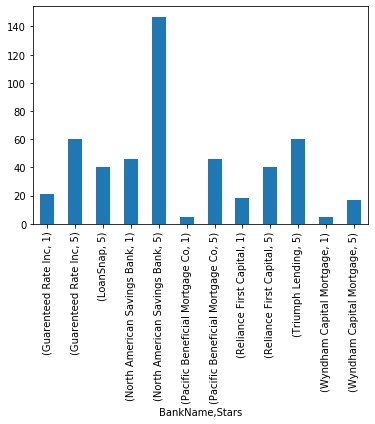

In [8]:
a = data.groupby(['BankName', 'Stars'])['Stars'].count()
a.plot.bar()
plt.show()

### Spliting data into Train and Test

In [9]:
# define X and y
X = data.Reviews
y = data.Stars

# split the new DataFrame into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=1)
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(378,)
(127,)
(378,)
(127,)


### Tokenization

In [10]:
def tokenization(text):
    text = word_tokenize(text)
    return text

In [11]:
train_tokens = train_X.apply(lambda x : tokenization(x))
test_tokens = test_X.apply(lambda  x: tokenization(x))

### POS Tagging

In [12]:
def pos_tagging(text):
    text = nltk.pos_tag(text)
    return text

In [13]:
train_pos_tag = train_tokens.apply(lambda x : pos_tagging(x))
test_pos_tag = test_tokens.apply(lambda x : pos_tagging(x))

### Calculating Sentiment analysis using Textblob module

In [14]:
polarity = data["Reviews"].apply(lambda x : TextBlob(x).sentiment.polarity )

In [15]:
data.Stars.value_counts()

5    410
1     95
Name: Stars, dtype: int64

### Creating user defined functions for clean the text and pre-process the data

In [16]:
#Abbrevations and Words correction
def clean_text(text):
    text = text.lower()
    text = text.strip()
    text = re.sub(r' +', ' ', text)
    text = re.sub(r"read more", '', text)
    text = re.sub(r"[-()\"#/@;:{}`+=~|.!?,'0-9]", "", text)
    return text

In [17]:
train_X = train_X.apply(lambda x : clean_text(x))
test_X = test_X.apply(lambda x : clean_text(x))

In [18]:
stop = set(nltk.corpus.stopwords.words('english'))      

In [19]:
import string
def pre_process(text):
    text = text.apply(lambda x : " ".join(x for x in x.split() if x not in stop)) #Removing stop words
#     text = text.apply(lambda x : str(TextBlob(x).correct()))  # Correct spelling 
    return text

In [20]:
train_X = pre_process(train_X)
test_X = pre_process(test_X)

### Lemmatization

In [21]:
def lemmatization(text):
    text = text.apply(lambda x : " ".join([Word(word).lemmatize() for word in x.split()])) 
    text = text.apply(lambda x : " ".join(word for word, pos in nltk.pos_tag(x.split()) if pos not in ['NN','NNS','NNP','NNPS'])) #Removing nouns etc
    return text

In [22]:
train_X = lemmatization(train_X)
test_X = lemmatization(test_X)

### Vectorization for Train 

In [23]:
#Train
count_vect = CountVectorizer(analyzer = 'word', token_pattern = r'\w{1,}', 
                             ngram_range = (1, 2), 
                             min_df = 0.01, 
                             encoding = 'latin-1',
                             max_df = 0.80
                             )
xtrain_count = count_vect.fit_transform(train_X)

In [24]:
xtrain_count

<378x530 sparse matrix of type '<class 'numpy.int64'>'
	with 5982 stored elements in Compressed Sparse Row format>

### View the document term metrics

In [25]:
dtm = xtrain_count.toarray()
dtm

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [26]:
tokens = count_vect.get_feature_names()
print(tokens[:20])

['able', 'able close', 'able get', 'absolutely', 'accept', 'accommodating', 'achieve', 'across', 'actual', 'actually', 'adam', 'additional', 'agent', 'agreed', 'alex', 'almost', 'along', 'already', 'also', 'always']


In [27]:
# count how many times EACH token appears across ALL messages in X_train_dtm
train_X_counts = np.sum(dtm, axis = 0)
train_X_counts

array([ 35,   4,   5,   8,   6,   5,   4,  10,   6,   4,  21,   9,   4,
         6,  35,  11,  12,  11,  34,  64,   4,  11,  18,   7,   7,  23,
        22,  23,   8,  11,   8,   5,  11,  11,  22,   9,   6,   4,  20,
         4,   5,   9,  34,   6,   8,   6,   4,  20,   4,   4,   5,  16,
        75,   8,   4,   4,  11,  22,  19,   7,  18,   4,   4,   6,   6,
        24,  38,   4,   6,   7,  25,   4,  12,   4,   4,   4,   7,  11,
         8,   5,  11,  41,  49,  34,   4,  12,   9,   6,   5,   4,   7,
         9,  13,  10,  13,   8,   4,   4,  17,   4,   5,   6,  53,   4,
         5,  13,   6,  15,   4,  10,  12,  22,   9,  11,   6,  21,   5,
         4,   7,   4,  34,   6,  11,   6,   5,   6,  46,   4,   6,  19,
        14,  12,   5,   6,   5,  14,   9,  35,   7,   4,   4,  41,  24,
        48,   4,   8,  18,   7,   7,   9,   7,  10,   7,   6,  13,  35,
         7,   4,  10,  14,   9,  18,   7,  18,   6,   6,   8,  20,  10,
         4,   5,   6,  61,   9,  10,   4,   4,  14,  11,   5,  1

In [28]:
# create a DataFrame of tokens with their counts
token_count = pd.DataFrame({'token' : tokens, 'count' : train_X_counts})
token_count.sort_values(by = ['count'], ascending = False, inplace = True)
token_count.head()

,token,count
519,would,166
477,u,126
205,great,109
379,recommend,105
282,made,75


Text(0.5, 1.0, 'Top 20 Tokens')

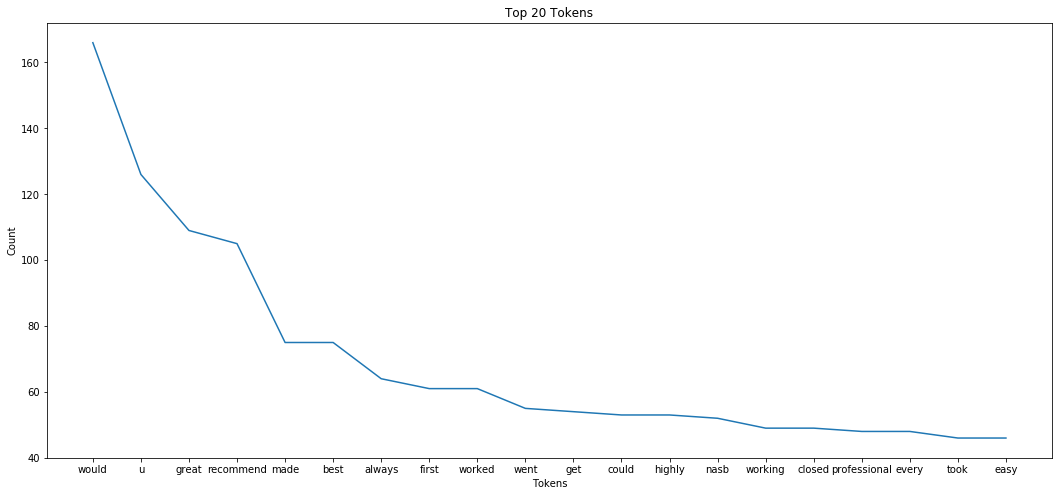

In [29]:
plt.figure(figsize = (18, 8))
plt.plot('token', 'count', data = token_count[:20])
plt.xlabel('Tokens')
plt.ylabel('Count')
plt.title('Top 20 Tokens')

### Word Cloud

In [30]:
frequency_words_wo_stop= {}
for data_review in train_X:
    tokens = nltk.wordpunct_tokenize(data_review.lower())
    for token in tokens:
        if token.lower() not in stop:
            if token in frequency_words_wo_stop:
                count = frequency_words_wo_stop[token]
                count = count + 1
                frequency_words_wo_stop[token] = count
            else:
                frequency_words_wo_stop[token] = 1

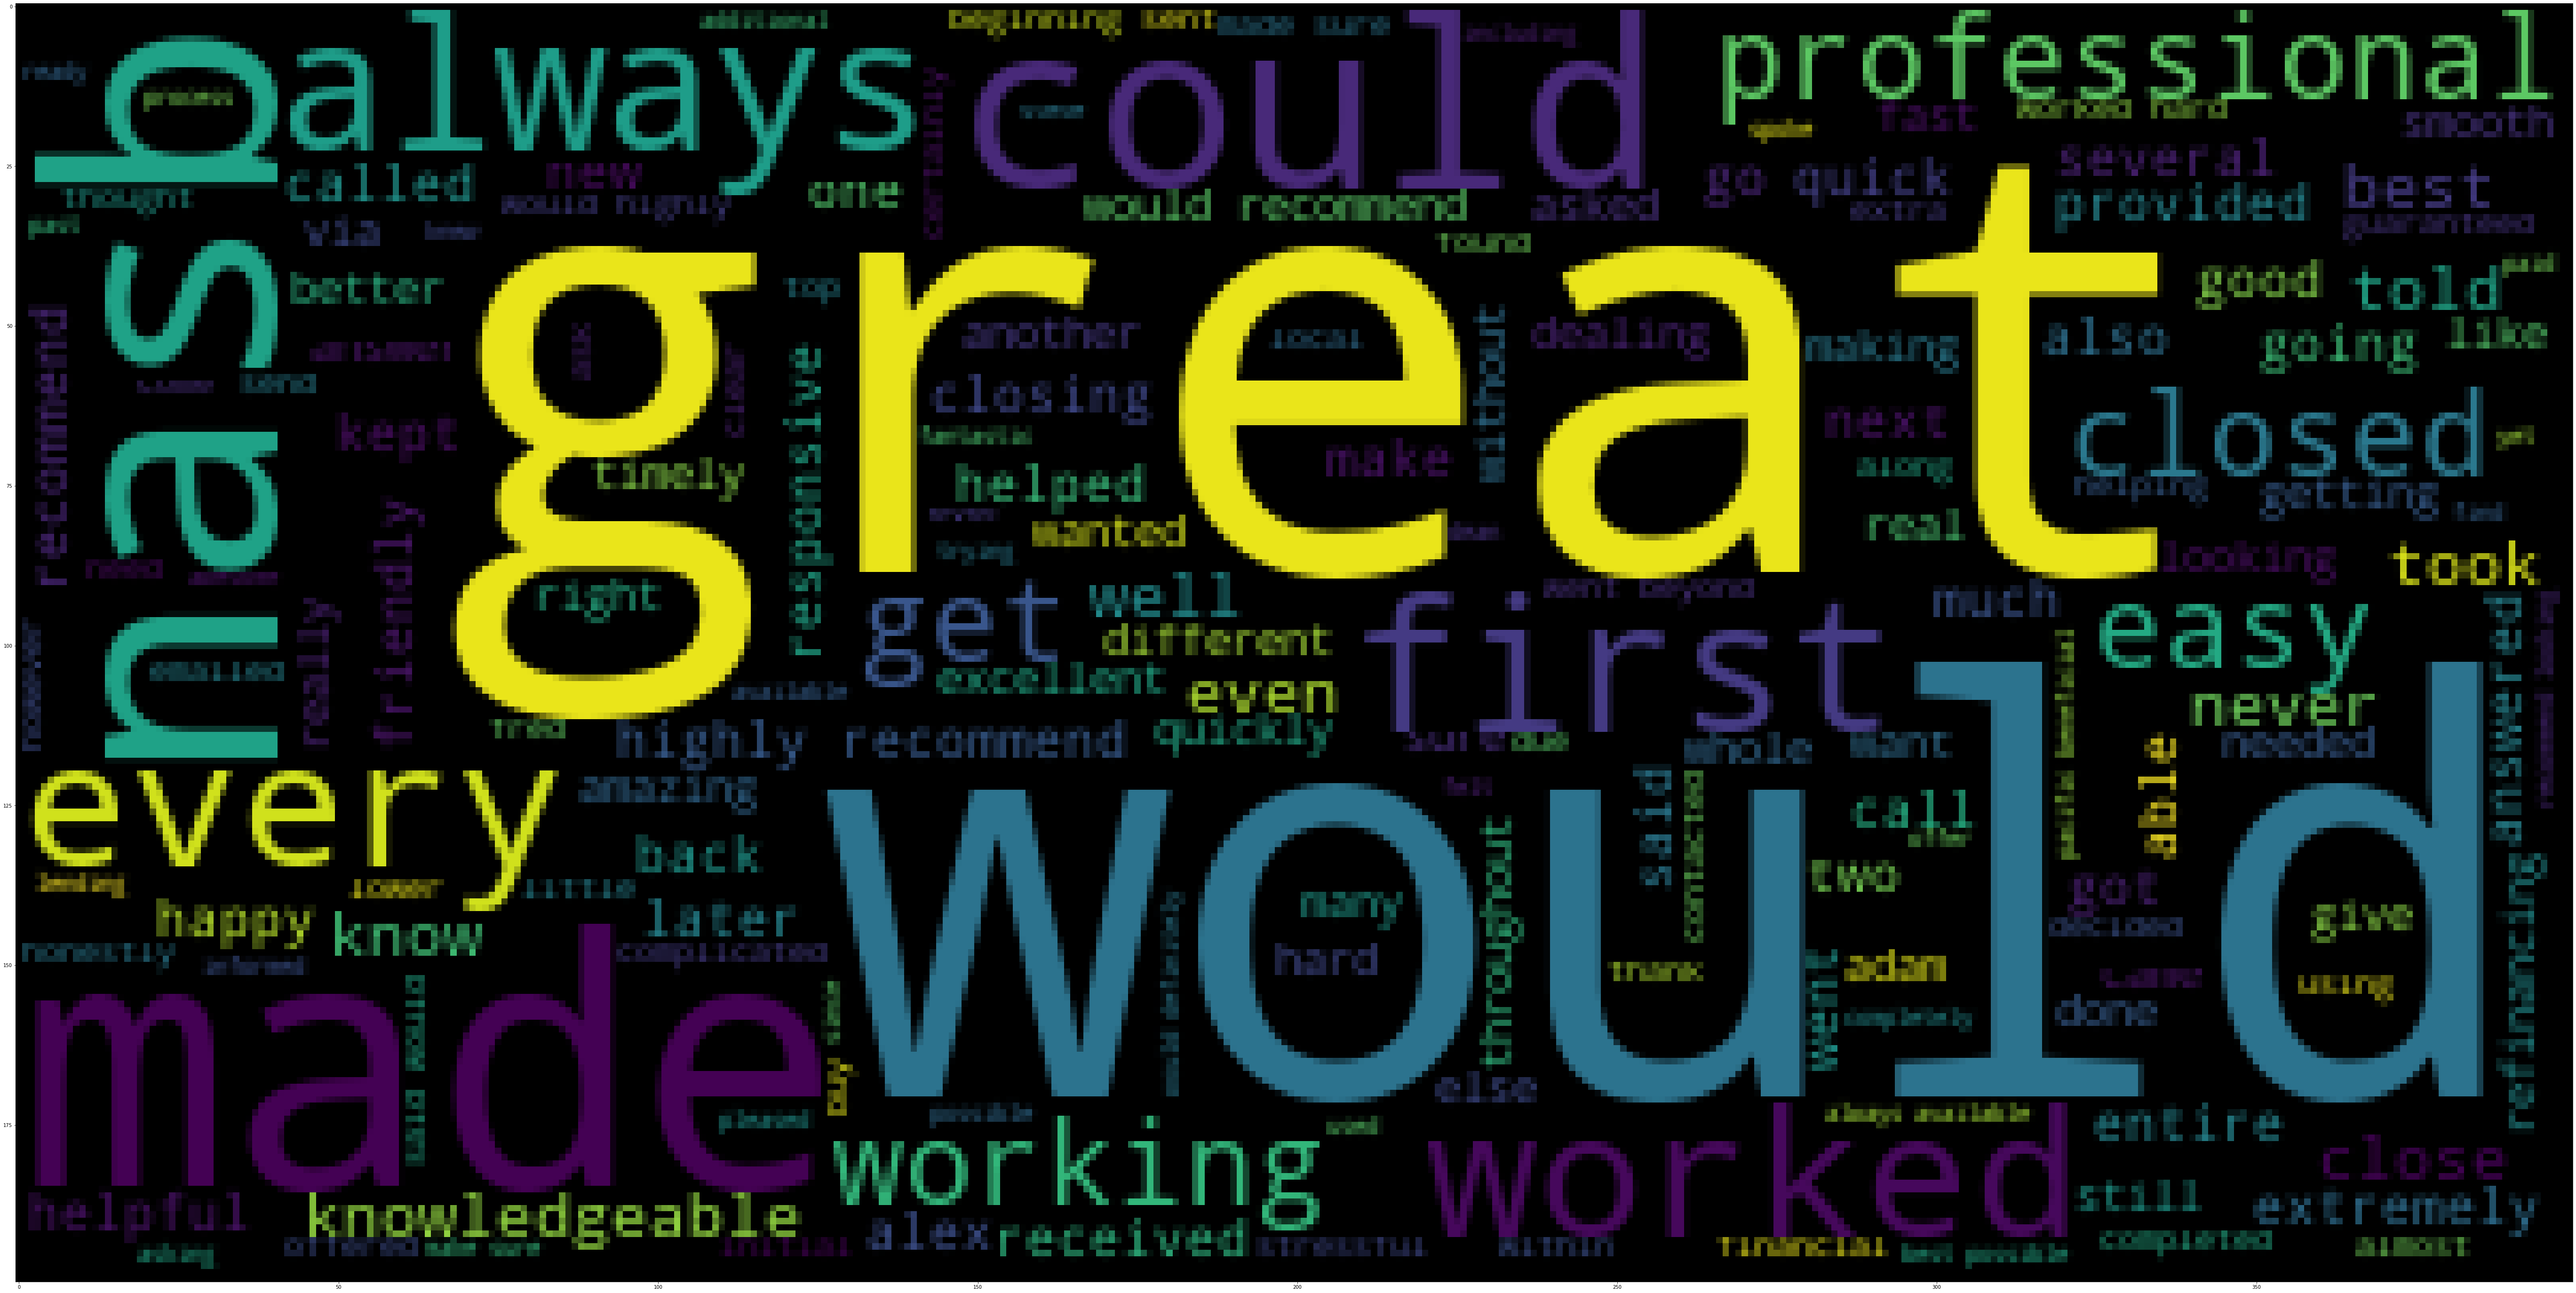

In [31]:
wordcloud = WordCloud(stopwords = []).generate(' '.join(train_X.tolist()))

fig = plt.figure(figsize = (100,50))
plt.imshow(wordcloud)

### Classify reviews to positive, negative and neutral

In [32]:
# We use textblob utility to calculate polarity
def get_sentiment(text):
    # create TextBlob object of passed text 
    analysis = TextBlob(text) 
    # set sentiment 
    if analysis.sentiment.polarity > 0: 
        return 'positive'
    elif analysis.sentiment.polarity == 0: 
        return 'neutral'
    else: 
        return 'negative'

In [33]:
df= pd.DataFrame()
df['Reviews'] = train_X
df['sentiment'] = train_X.apply(lambda x : get_sentiment(x))
df.head()

,Reviews,sentiment
501,started ran without agreed told could close le...,positive
172,great knowledgeable responsive always got back...,positive
80,working first kept well informed every refinan...,positive
46,started ran without agreed told could close le...,positive
318,agree easy clear knowledgeable direct worked w...,positive


           Reviews
sentiment         
negative        31
neutral         16
positive       331


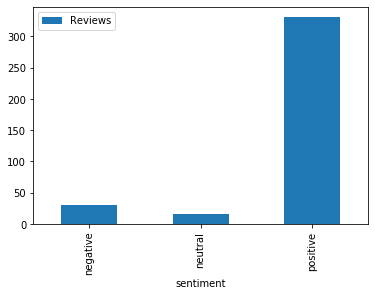

In [34]:
a = df.groupby(['sentiment']).count()
print(a)
a.plot.bar()
plt.show()

In [35]:
# picking positive Reviews from Reviews 
Pos_Reviews = df[df.sentiment == 'positive']
# percentage of positive Reviews 
print("Positive Reviews percentage: {} %".format(100*len(Pos_Reviews) / len(df.Reviews))) 

Positive Reviews percentage: 87.56613756613757 %


In [36]:
# picking negative Reviews from Reviews 
Neg_Reviews = df[df.sentiment == 'negative'] 
# percentage of negative Reviews 
print("Negative Reviews percentage: {} %".format(100*len(Neg_Reviews) / len(df.Reviews))) 

Negative Reviews percentage: 8.201058201058201 %


In [37]:
# percentage of neutral Reviews 
print("Neutral Reviews percentage: {} %".format(100*(len(df.Reviews) - len(Neg_Reviews) - len(Pos_Reviews)) / len(df.Reviews))) 

Neutral Reviews percentage: 4.232804232804233 %


In [38]:
# Top 5 positive reviews
Pos_Reviews.head(5)['Reviews'].tolist()

['started ran without agreed told could close le took still asking closing household good unpacked told could used fly id take doc notary back also get send accept personal five later driving nc already sent could send four purchased past',
 'great knowledgeable responsive always got back u quickly answer tedious made easy',
 'working first kept well informed every refinancing also made sure understood completely fast responding helping',
 'started ran without agreed told could close le took still asking closing household good unpacked told could used fly id take doc notary back also get send accept personal five later driving nc already sent could send four purchased past read',
 'agree easy clear knowledgeable direct worked well asks document smooth successful funded happy worked michele dealing']

In [39]:
# Top 5 negative reviews
Neg_Reviews.head(5)['Reviews'].tolist()

['first capitoldo kenneth youi frustrated talked would always saylet call back minutesi hear happened probably timesit extremely badwe raise took probably monthbut took little get said lost also motorcycle supposed get ill call back mindidnt called back next',
 'taking soon found stopped would return call finally got hold short little asked detail went different',
 'worked hard ensure able beautiful difficult possibly went wrong managed go wrong frustrated kept u right helped u resolve able close forever grateful defiantly recommend needing',
 'aware critical delayed refinancing several finally upon also several later promised pay wrong due late next thomas cordial stayed constant overall incorrect due would make impossible whole',
 'new federal made tedious consuming seemed bit high seemed like explaining obvious']

### K-Means Cluster Analysis

In [40]:
from sklearn.cluster import KMeans 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

In [41]:
tf_idf_vectorizor = TfidfVectorizer(max_features = 15000)
tf_idf = tf_idf_vectorizor.fit_transform(train_X)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

In [42]:
tf_idf_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [43]:
class Kmeans:
    
    def __init__(self, k, seed = None, max_iter = 200):
        self.k = k
        self.seed = seed
        if self.seed is not None:
            np.random.seed(self.seed)
        self.max_iter = max_iter
    
    def initialise_centroids(self, data):
        
        initial_centroids = np.random.permutation(data.shape[0])[:self.k]
        self.centroids = data[initial_centroids]
        return self.centroids
    
    def assign_clusters(self, data):
       
        if data.ndim == 1:
            data = data.reshape(-1, 1)
        
        dist_to_centroid =  pairwise_distances(data, self.centroids, metric = 'euclidean')
        self.cluster_labels = np.argmin(dist_to_centroid, axis = 1)
        return  self.cluster_labels
    
    def update_centroids(self, data):
       
        self.centroids = np.array([data[self.cluster_labels == i].mean(axis = 0) for i in range(self.k)])
        return self.centroids
    
    def predict(self, data):
        return self.assign_clusters(data)
    
    def fit_kmeans(self, data):
      
        self.centroids = self.initialise_centroids(data)
        
        # Main kmeans loop
        for iter in range(self.max_iter):

            self.cluster_labels = self.assign_clusters(data)
            self.centroids = self.update_centroids(data)          
            if iter % 100 == 0:
                print("Running Model Iteration %d " %iter)
        print("Model finished running")
        return self  

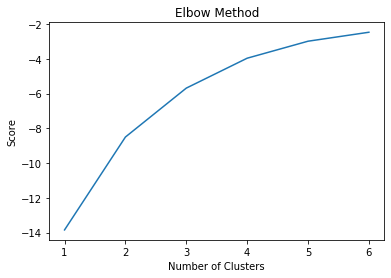

In [44]:
number_clusters = range(1, 7)
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

Running Model Iteration 0 
Running Model Iteration 100 
Running Model Iteration 200 
Running Model Iteration 300 
Running Model Iteration 400 
Running Model Iteration 500 
Model finished running


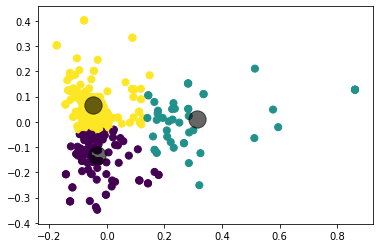

In [45]:
test_e = Kmeans(3, 1, 600)
fitted = test_e.fit_kmeans(Y_sklearn)
predicted_values = test_e.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c = predicted_values, s = 50, cmap = 'viridis')

centers = fitted.centroids
plt.scatter(centers[:, 0], centers[:, 1], c = 'black', s = 300, alpha = 0.6);

In [46]:
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters = 3, max_iter = 600, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

In [47]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizor.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
df1,df2,df3 = get_top_features_cluster(tf_idf_array, prediction, 15)
df1

,features,score
0,recommend,0.078162
1,best,0.068909
2,worked,0.063799
3,highly,0.058761
4,would,0.052929
5,knowledgeable,0.047682
6,made,0.039211
7,easy,0.036413
8,possible,0.035759
9,helped,0.034851


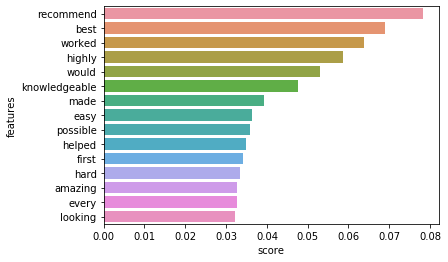

In [48]:
# cluster1 top 15 words
sns.barplot(x = 'score', y = "features", data = df1)
plt.show()

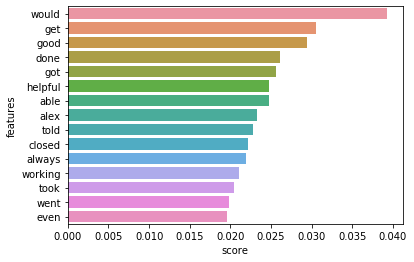

In [49]:
# cluster2 top 15 words 
sns.barplot(x = 'score', y = "features", data = df2)
plt.show()

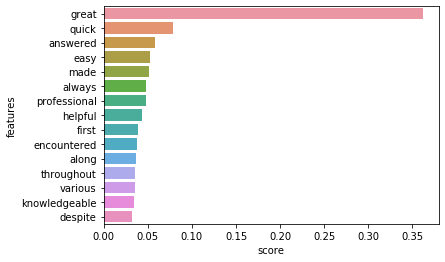

In [50]:
# cluster3 top 15 words
sns.barplot(x = 'score', y = "features", data = df3)
plt.show()

### Vectorization (Count, Tfidf, Hashing)
        - Charter level
        - Word level
        - n-grams

### Vectorization (count, tfidf) for both train & test (word level tf-idf)

In [51]:
#Train
count_vect = CountVectorizer(analyzer = 'word', 
                             token_pattern = '\w{1,}', 
                             ngram_range = (1, 1), 
                             min_df = 5,  
                             max_features = 2000)
train_X_count = count_vect.fit_transform(train_X)

tfidf_transformer = TfidfTransformer()
train_X_tfidf = tfidf_transformer.fit_transform(train_X_count)

#Test
#count_vect = CountVectorizer()
test_X_count = count_vect.transform(test_X)

#tfidf_transformer = TfidfTransformer()
test_X_tfidf = tfidf_transformer.transform(test_X_count)

In [52]:
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer = 'word', token_pattern = '\w{1,}', ngram_range = (1, 2), max_features = 2000)
tfidf_vect_ngram.fit(data['Reviews'])
train_X_tfidf_ngram =  tfidf_vect_ngram.transform(train_X)
test_X_tfidf_ngram =  tfidf_vect_ngram.transform(test_X)

In [53]:
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer = 'char', token_pattern= ' \w{1,}', ngram_range = (1, 2), max_features = 2000)
tfidf_vect_ngram_chars.fit(data['Reviews'])
train_X_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_X) 
test_X_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(test_X)

### Topic Modeling

In [54]:
# train a LDA Model
lda_model = decomposition.LatentDirichletAllocation(n_components = 20, learning_method = 'online', max_iter = 50)
topics_X = lda_model.fit_transform(train_X_tfidf)
topic_word = lda_model.components_ 
vocab = count_vect.get_feature_names()

In [55]:
# view the topic models
n_top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))

topic_summaries

['lending offer satisfied competitive nasb chose promised tree completely whole',
 'competitive efficient tried hold professional great fast got provided closing',
 'appreciated friendly efficient timely provided could send oriented entire told',
 'responsive real throughout good informed great entire kept suggested bad',
 'lender took local friend seemed gave recommend would process trusted',
 'nasb unlike specifically said sent difficult four initially became two',
 'poor done got even contacted couldnt sign recommended closing communicated',
 'awesome nasb u impressed aspect taken necessary several ensure clear',
 'wyndham wrong emailed personal give without found called encountered u',
 'good total accommodating helpful easy sign im initially trusted asking',
 'different upon took felt financial needed worked entire calm based',
 'great best professional recommend quick worked possible highly helpful experienced',
 'unprofessional previous contacted accommodating professional expla

### Create user defined function for train the models

In [56]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid,  valid_y, is_neural_net = False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis = -1)
    
    return metrics.accuracy_score(predictions, valid_y)

## Building different models with different vectors

### Naive Bayes

In [57]:
#Naive Bayes
# Naive Bayes on Count Vectors and TF-IDF
accuracy_L1 = train_model(naive_bayes.MultinomialNB(), train_X_tfidf, train_y, test_X_tfidf, test_y)
print("NB  for L1, Count Vectors: ", accuracy_L1)



# Naive Bayes on Word Level TF IDF Vectors
accuracy_L1 = train_model(naive_bayes.MultinomialNB(), train_X_count, train_y, test_X_count, test_y)
print("NB  for L1, WordLevel TF-IDF: ", accuracy_L1)



# Naive Bayes on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(naive_bayes.MultinomialNB(), train_X_tfidf_ngram, train_y, test_X_tfidf_ngram, test_y)
print("NB  for L1, N-Gram Vectors: ", accuracy_L1)



# Naive Bayes on Character Level TF IDF Vectors
accuracy_L1 = train_model(naive_bayes.MultinomialNB(), train_X_tfidf_ngram_chars, train_y, test_X_tfidf_ngram_chars, test_y)
print("NB for L1, CharLevel Vectors: ", accuracy_L1)

NB  for L1, Count Vectors:  0.8503937007874016
NB  for L1, WordLevel TF-IDF:  0.9212598425196851
NB  for L1, N-Gram Vectors:  0.8188976377952756
NB for L1, CharLevel Vectors:  0.8031496062992126


### Logistic Regression

In [58]:
# Logistic Regression on Count Vectors and TF-IDF
accuracy_L1 = train_model(LogisticRegression(), train_X_tfidf, train_y, test_X_tfidf, test_y)
print("LR  for L1, Count Vectors: ", accuracy_L1)



# Logistic Regression on Word Level TF IDF Vectors
accuracy_L1 = train_model(LogisticRegression(), train_X_count, train_y, test_X_count, test_y)
print("LR  for L1, WordLevel TF-IDF: ", accuracy_L1)



# Logistic Regression on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(LogisticRegression(), train_X_tfidf_ngram, train_y, test_X_tfidf_ngram, test_y)
print("LR  for L1, N-Gram Vectors: ", accuracy_L1)



# Logistic Regression on Character Level TF IDF Vectors
accuracy_L1 = train_model(LogisticRegression(), train_X_tfidf_ngram_chars, train_y, test_X_tfidf_ngram_chars, test_y)
print("LR for L1, CharLevel Vectors: ", accuracy_L1)

LR  for L1, Count Vectors:  0.84251968503937
LR  for L1, WordLevel TF-IDF:  0.9291338582677166
LR  for L1, N-Gram Vectors:  0.84251968503937
LR for L1, CharLevel Vectors:  0.8031496062992126


### Linear SVM

In [59]:
# Linear SVC on Count Vectors and TF-IDF
accuracy_L1 = train_model(svm.LinearSVC(), train_X_tfidf, train_y, test_X_tfidf, test_y)
print("SVC  for L1, Count Vectors: ", accuracy_L1)



# Linear SVC on Word Level TF IDF Vectors
accuracy_L1 = train_model(svm.LinearSVC(), train_X_count, train_y, test_X_count, test_y)
print("SVC  for L1, WordLevel TF-IDF: ", accuracy_L1)



# Linear SVC on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(svm.LinearSVC(), train_X_tfidf_ngram, train_y, test_X_tfidf_ngram, test_y)
print("SVC  for L1, N-Gram Vectors: ", accuracy_L1)



# Linear SVC on Character Level TF IDF Vectors
accuracy_L1 = train_model(svm.LinearSVC(), train_X_tfidf_ngram_chars, train_y, test_X_tfidf_ngram_chars, test_y)
print("SVC for L1, CharLevel Vectors: ", accuracy_L1)

SVC  for L1, Count Vectors:  0.937007874015748
SVC  for L1, WordLevel TF-IDF:  0.952755905511811
SVC  for L1, N-Gram Vectors:  0.9763779527559056
SVC for L1, CharLevel Vectors:  0.9448818897637795


### Random Forest Classifier
### Bagging

In [60]:
# Random Forest Classifier on Count Vectors and TF-IDF
accuracy_L1 = train_model(ensemble.RandomForestClassifier(), train_X_tfidf, train_y, test_X_tfidf, test_y)
print("Bagging for L1, Count Vectors: ", accuracy_L1)



# Random Forest Classifier on Word Level TF IDF Vectors
accuracy_L1 = train_model(ensemble.RandomForestClassifier(), train_X_count, train_y, test_X_count, test_y)
print("Bagging for L1, WordLevel TF-IDF: ", accuracy_L1)



# Random Forest Classifier on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(ensemble.RandomForestClassifier(), train_X_tfidf_ngram, train_y, test_X_tfidf_ngram, test_y)
print("Bagging for L1, N-Gram Vectors: ", accuracy_L1)



# Random Forest Classifier on Character Level TF IDF Vectors
accuracy_L1 = train_model(ensemble.RandomForestClassifier(), train_X_tfidf_ngram_chars, train_y, test_X_tfidf_ngram_chars, test_y)
print("Bagging for L1, CharLevel Vectors: ", accuracy_L1)

Bagging for L1, Count Vectors:  0.8818897637795275
Bagging for L1, WordLevel TF-IDF:  0.937007874015748
Bagging for L1, N-Gram Vectors:  0.905511811023622
Bagging for L1, CharLevel Vectors:  0.8740157480314961


### xgboost Classifier
### Boosting

In [61]:
# XGB Classifier on Count Vectors and TF-IDF
accuracy_L1 = train_model(xgboost.XGBClassifier(), train_X_tfidf, train_y, test_X_tfidf, test_y)
print("Boosting for L1, Count Vectors: ", accuracy_L1)



# XGB Classifier on Word Level TF IDF Vectors
accuracy_L1 = train_model(xgboost.XGBClassifier(), train_X_count, train_y, test_X_count, test_y)
print("Boosting for L1, WordLevel TF-IDF: ", accuracy_L1)



# XGB Classifier on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(xgboost.XGBClassifier(), train_X_tfidf_ngram, train_y, test_X_tfidf_ngram, test_y)
print("Boosting for L1, N-Gram Vectors: ", accuracy_L1)



# XGB Classifier on Character Level TF IDF Vectors
accuracy_L1 = train_model(xgboost.XGBClassifier(), train_X_tfidf_ngram_chars, train_y, test_X_tfidf_ngram_chars, test_y)
print("Boosting for L1, CharLevel Vectors: ", accuracy_L1)

Boosting for L1, Count Vectors:  0.8976377952755905
Boosting for L1, WordLevel TF-IDF:  0.9212598425196851
Boosting for L1, N-Gram Vectors:  0.905511811023622
Boosting for L1, CharLevel Vectors:  0.9212598425196851


### Predicting star ratings using reviews

In [62]:
# Balancing the Data
from collections import Counter
 
def balance_classes(xs, ys):
    """Undersample xs, ys to balance classes."""
    freqs = Counter(ys)
 
    # the least common class is the maximum number we want for all classes
    max_allowable = freqs.most_common()[-1][1]
    num_added = {clss: 0 for clss in freqs.keys()}
    new_ys = []
    new_xs = []
    for i, y in enumerate(ys):
        if (num_added[y] < max_allowable):
            new_ys.append(y)
            new_xs.append(xs[i])
            num_added[y] += 1
    return(new_xs, new_ys)

In [63]:
print(Counter(train_y))
balanced_x, balanced_y = balance_classes(train_X.tolist(), train_y.tolist())
print(Counter(balanced_y))

Counter({5: 308, 1: 70})
Counter({1: 70, 5: 70})


In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer
 
vectorizer = TfidfVectorizer(ngram_range = (1,2))
vectors = vectorizer.fit_transform(balanced_x)

In [65]:
train_X, test_X, train_y, test_y = train_test_split(vectors, balanced_y, test_size = 0.3, random_state = 345)

In [66]:
from sklearn.svm import LinearSVC
 
# initialise the SVM classifier
classifier = LinearSVC()
 
# train the classifier
classifier.fit(train_X, train_y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [67]:
# prediction of train data
train_preds = classifier.predict(train_X)
print(list(train_preds[:10]))
print(train_y[:10])

[1, 5, 1, 1, 5, 1, 1, 5, 5, 5]
[1, 5, 1, 1, 5, 1, 1, 5, 5, 5]


In [68]:
# prediction of train data
test_preds = classifier.predict(test_X)
print(list(test_preds[:10]))
print(test_y[:10])

[5, 5, 5, 5, 5, 5, 1, 5, 1, 5]
[5, 5, 5, 1, 5, 5, 1, 5, 1, 5]


In [69]:
from sklearn.metrics import accuracy_score
print(accuracy_score(test_y, test_preds))

0.9523809523809523
